In [1]:
import numpy as np
import mne
import os
import sys
from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

## EEG Motor Movement/Imagery Dataset

1. https://www.physionet.org/content/eegmmidb/1.0.0/
2. Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N., Wolpaw, J.R. BCI2000: A General-Purpose Brain-Computer Interface (BCI) System. IEEE Transactions on Biomedical Engineering 51(6):1034-1043, 2004
3. https://mne.tools/stable/auto_examples/index.html

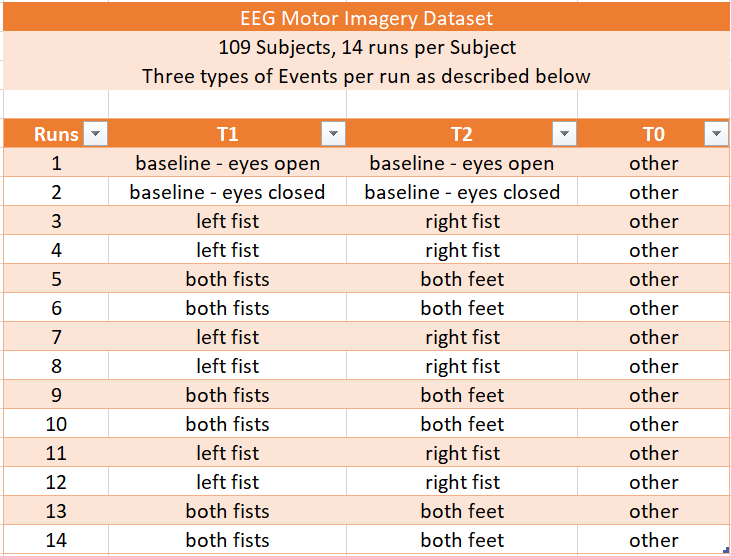

### Defining a motorImagery class for Data Loading and Pre-processing

In [2]:
class motorImagery:
    def __init__(self, path=None, subjects=[1], runs=[1]):
        self.path = path
        self.edf_filenames = self.get_filenames(path)
        self.raw = self.load_eeg(subjects, runs)
        
    def get_filenames(self, path):
        file = open(dataset_path+'RECORDS')
        edf_filenames = file.readlines()
        file.close()
        edf_filenames = [fname.rstrip() for fname in edf_filenames]
        return edf_filenames
    
    def load_eeg(self, subjects, runs):    #load -> standardize -> notch_filter -> bandpass filter -> return
    
        fno = self.get_fileIndices(subjects, runs)
        print('Loading files at index:', fno)
        
        raw_eegs = []
        for idx,i in enumerate(fno):
            path_file = os.path.join(self.path, self.edf_filenames[i])
            sys.stdout.write(f"\rLoading file #{idx+1}/{len(fno)}: {path_file}")
            raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
            raw_eegs.append(raw)

        raw = mne.io.concatenate_raws(raw_eegs)     # Concatenate all EEGs together
        eegbci.standardize(raw)                     # Standardize channel names
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        return raw                                  
    
    def get_fileIndices(self, subjects, runs):
        fno = []
        subjects = [s-1 for s in subjects]  # start from 0, 1, 2, ...
        for subject in subjects:
            for run in runs:
                fno.append(subject*14+run-1)   # 14 runs per subject
        return fno
    
    def apply_filter(self, freq):
        # Remove power line noise atrifacts at 50 Hz <-- European data so 50Hz powerline freq
        #self.raw.notch_filter(50)
        # Remove higher frequencies as they are redundant for analysis.
        low_freq, high_freq = freq
        self.raw.filter(low_freq, high_freq, fir_design='firwin')
        
    def get_ica(self, n=16):
        self.ica = mne.preprocessing.ICA(n_components=n, max_iter='auto', random_state=97)
        self.ica.fit(self.raw)
        self.raw.load_data()
        self.ica.plot_sources(self.raw)
        self.ica.plot_components()
        
    def exclude_ic(self, channels):
        self.ica.exclude = channels
        self.ica.apply(self.raw)

    def get_events(self):
        event_id = dict(T1=2, T2=3)        # Define the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        # We don't need it for now but lets include it as it is a part of the pipeline of eeg classification
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')

        # tmin and tmax are relative to the event onset time. They decide the time interval (relative to event onset) taken to 
        # form the epoch from eeg signal. 
        tmin = -1  # A second before event cue 
        tmax = 4   # Four seconds after cue. Most events are of 4.1 or 4.2 seconds long as described in annotations.

        # Read epochs (only the events described in our event_id will be included for training)
        # For future try to use baseline subtraction method 
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True)

        # Only eeg signals in time interval 1-2 sec will be used for training -> 1 sec after event cue to 2 sec after cue.
        # This is to avoid the evoked potentials arising in brain in response to event cue.
        epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
        montage = mne.channels.make_standard_montage('standard_1005')
        epochs_train.set_montage(montage)
        
        return epochs_train
    
    def downsample(self, epochs, factor):
        return epochs.decimate(factor)
        
    def return_epochs(self, freq=(1, 35), dsamplingFactor=1 ):
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        self.epochs = self.downsample(self.epochs, dsamplingFactor)
        self.labels = self.epochs.events[:,-1] - 2        # Convert from 2,3 to 0,1 and assign to labels for training
        return self.epochs, self.labels
    
    def get_X_y(self, freq=(1, 35), sampling=1):
        try:
            return self.epochs.get_data(), self.labels
        except:
            self.return_epochs(freq, sampling)
            return self.epochs.get_data(), self.labels

### Experiment Design - #1

The task is to distinguish between hand motor imagery signals and feet movement motor imagery signals. We use EEG data from just one subject for this experiment. For the moment, we are not using any Artifact Handling techniques. We use Common Spatial Pattern Algorithm to apply spatial filter to EEG signals and compare results to just using raw signal values. Furthermore, we are using Logistic Regression model to classify the CSP filtered signals. The number of components resulting after application of spatial filters is a hyperparameter and will be determined using cross validation. We will see the variation in this hyperparameter as we increase the number of subjects.

Subject = 1

Channel Selection = False

Filtering = True (7-30 Hz Bandpass)

Artifact Handling = False

Downsampling = None

Baseline = False

CSP = True

Classification Method = Logistic Regression


#### Loading data using the motorImagery class

In [3]:
dataset_path = os.path.join("H:\\","BCI Project","eeg-motor-movementimagery-dataset-1.0.0","files\\")
subjects = [1]
runs = [6,10,14]
eeg = motorImagery(dataset_path, subjects, runs)


Loading files at index: [5, 9, 13]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S001/S001R14.edf

#### Apply Bandpass Filter 

We apply bandpass filter from 1Hz to 35Hz. This filters out slow drift potentials in the low frequency range and the higher frequencies not needed for our analysis. Powerline artifacts at 50Hz are also filtered out.

In [4]:
eeg.apply_filter(freq=(7,30))

#### Extract Training data, X and y

In [5]:
X, y = eeg.get_X_y()
X.shape

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Loading data for 45 events and 801 original time points ...
0 bad epochs dropped


(45, 64, 161)

#### Display the Two-Dimensional Training sample as an image

[1 0 0 1 0]


Text(0.5, 1.0, 'Class 0: Hands')

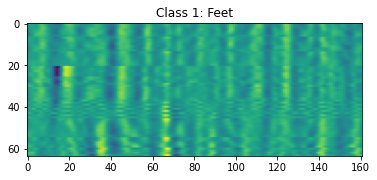

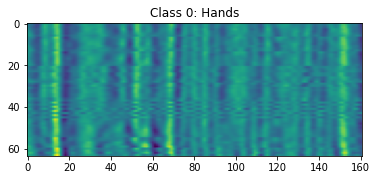

In [50]:
import matplotlib.pyplot as plt

print(y[:5])
plt.imshow(X[0])
plt.title("Class 1: Feet")
plt.figure()
plt.imshow(X[2])
plt.title("Class 0: Hands")

#### Logistic Regression using Raw signal values

#### Split into Training and test samples

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

##### Reshape X_train and X_test from 2D array to a Vector

This step is required for input into the Logistic Regression algorithm.

In [52]:
X_train = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2])
X_train.shape
X_test = X_test.reshape(-1, X_test.shape[1]*X_test.shape[2])
X_test.shape

(14, 10304)

##### Train & Predict

In [53]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.43      1.00      0.60         6

    accuracy                           0.43        14
   macro avg       0.21      0.50      0.30        14
weighted avg       0.18      0.43      0.26        14



C:\pythonBCI\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\pythonBCI\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\pythonBCI\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Logistic Regression using CSP filtered values

#### Split into Training and test samples

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

##### Spatial Filtering using Common Spatial Patterns Algorithm

In [7]:
csp = mne.decoding.CSP(n_components=3, norm_trace=True)
X_train_csp = csp.fit_transform(X_train, y_train)
X_test_csp = csp.transform(X_test)
X_train_csp.shape

Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 64 dim * 8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9e-05 (2.2e-16 eps * 64 dim * 6.4e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


(31, 3)

In [62]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train_csp, y_train)
y_hat = model.predict(X_test_csp)
accuracy = np.sum(y_hat==y_test)/y_test.shape[0]
print(accuracy)

0.8571428571428571


In [63]:
print(dir(LogisticRegression))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_feature_names', '_check_n_features', '_estimator_type', '_get_param_names', '_get_tags', '_more_tags', '_predict_proba_lr', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_validate_data', 'decision_function', 'densify', 'fit', 'get_params', 'predict', 'predict_log_proba', 'predict_proba', 'score', 'set_params', 'sparsify']


#### Cross-Validation 

We perform cross-validation for determining the optimum Number of Components for CSP algorithm.

[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31]
Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.1e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.5e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 e

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.1e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 64 dim * 7.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps *

Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.6e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 64 dim * 7.5e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 64 dim * 7.6e+09  max singular v

Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.6e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular va

Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
  

Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.1e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.5e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
 

Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.1e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 64 dim * 7.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    E

    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.6e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 64 dim * 7.5e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 64 dim * 7.6e+09  max singular value)
    Estimated rank (mag): 64
    MAG: ra

    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.6e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
    Estimated rank (mag): 64
    MAG: ran

    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -

    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.5e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 

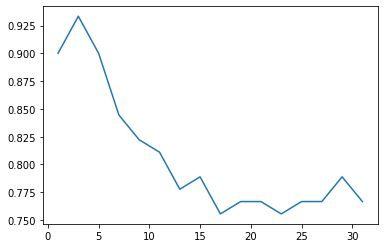

In [67]:
def train_model(csp_components, X, y):
    csp = mne.decoding.CSP(n_components=csp_components, norm_trace=True)
    log_regressor = LogisticRegression(max_iter=10000)
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    scores = []

    for train_idx, test_idx in cv.split(y):
        y_train, y_test = y[train_idx], y[test_idx]

        X_train = csp.fit_transform(X[train_idx], y_train)
        X_test = csp.transform(X[test_idx])

        # fit classifier
        log_regressor.fit(X_train, y_train)

        scores.append(log_regressor.score(X_test, y_test))
        
    return np.mean(scores) #Returns mean accuracy for this hyperparameter value

n_components = np.arange(1,33,2)
print(n_components)
accuracy = []

for number in n_components:
    accuracy.append( train_model(int(number), X, y) )

plt.plot(n_components, accuracy)
plt.xlabel("n_components CSP")
plt.ylabel("Classification Accuracy")
plt.title("Cross-Validation results")


### Experiment Design - #2

The task is to distinguish between hand motor imagery signals and feet movement motor imagery signals. We use EEG data from **two subjects** for this experiment. For the moment, we are not using any Artifact Handling techniques. We use Common Spatial Pattern Algorithm to apply spatial filter to EEG signals and compare results to just using raw signal values. Furthermore, we are using Logistic Regression model to classify the CSP filtered signals. The number of components resulting after application of spatial filters is a hyperparameter and will be determined using cross validation. We will see the variation in this hyperparameter as we increase the number of subjects.

Subjects = 2

Channel Selection = False

Filtering = True (7-30 Hz Bandpass)

Artifact Handling = False

Downsampling = None

Baseline = False

CSP = True

Classification Method = Logistic Regression

#### Loading data using the motorImagery class

In [77]:
dataset_path = os.path.join("H:\\","BCI Project","eeg-motor-movementimagery-dataset-1.0.0","files\\")
subjects = [1,3]
runs = [6,10,14]
eeg = motorImagery(dataset_path, subjects, runs)


Loading files at index: [5, 9, 13, 33, 37, 41]
Loading file #6/6: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S003/S003R14.edf

#### Apply Bandpass Filter 

We apply bandpass filter from 1Hz to 35Hz. This filters out slow drift potentials in the low frequency range and the higher frequencies not needed for our analysis. Powerline artifacts at 50Hz are also filtered out.

In [78]:
eeg.apply_filter(freq=(7,30))

#### Extract Training data, X and y

In [79]:
X, y = eeg.get_X_y()
X.shape

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Loading data for 90 events and 801 original time points ...
0 bad epochs dropped


(90, 64, 161)

#### Display the Two-Dimensional Training sample as an image

[1 0 0 1 0]


Text(0.5, 1.0, 'Class 0: Hands')

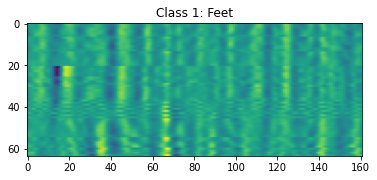

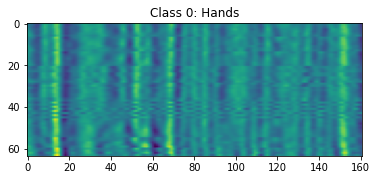

In [80]:
import matplotlib.pyplot as plt

print(y[:5])
plt.imshow(X[0])
plt.title("Class 1: Feet")
plt.figure()
plt.imshow(X[2])
plt.title("Class 0: Hands")

#### Logistic Regression using Raw signal values

#### Split into Training and test samples

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

##### Reshape X_train and X_test from 2D array to a Vector

This step is required for input into the Logistic Regression algorithm.

In [82]:
X_train = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2])
X_train.shape
X_test = X_test.reshape(-1, X_test.shape[1]*X_test.shape[2])
X_test.shape

(27, 10304)

##### Train & Predict

In [83]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.56      1.00      0.71        15

    accuracy                           0.56        27
   macro avg       0.28      0.50      0.36        27
weighted avg       0.31      0.56      0.40        27



C:\pythonBCI\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\pythonBCI\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\pythonBCI\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Logistic Regression using CSP filtered values

##### Spatial Filtering using Common Spatial Patterns Algorithm

#### Cross-Validation 

We perform cross-validation for determining the optimum Number of Components for CSP algorithm.

[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31]
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e

Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
    Using tolerance 0.00015 (2.2e-16 eps * 6

Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular v

Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)


Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    

Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Us

Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 

    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: ra

Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Us

Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Usin

Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Usin

Text(0.5, 1.0, 'Cross-Validation results')

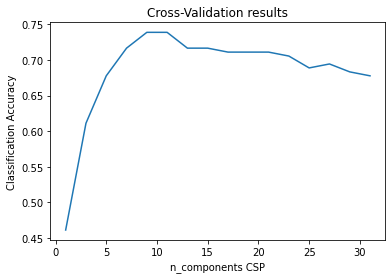

In [84]:
def train_model(csp_components, X, y):
    csp = mne.decoding.CSP(n_components=csp_components, norm_trace=True)
    log_regressor = LogisticRegression(max_iter=10000)
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    scores = []

    for train_idx, test_idx in cv.split(y):
        y_train, y_test = y[train_idx], y[test_idx]

        X_train = csp.fit_transform(X[train_idx], y_train)
        X_test = csp.transform(X[test_idx])

        # fit classifier
        log_regressor.fit(X_train, y_train)

        scores.append(log_regressor.score(X_test, y_test))
        
    return np.mean(scores) #Returns mean accuracy for this hyperparameter value

n_components = np.arange(1,33,2)
print(n_components)
accuracy = []

for number in n_components:
    accuracy.append( train_model(int(number), X, y) )

plt.plot(n_components, accuracy)
plt.xlabel("n_components CSP")
plt.ylabel("Classification Accuracy")
plt.title("Cross-Validation results")



### Experiment Design - #3

The task is to distinguish between hand motor imagery signals and feet movement motor imagery signals. We use EEG data from **four subjects** for this experiment. For the moment, we are not using any Artifact Handling techniques. We use Common Spatial Pattern Algorithm to apply spatial filter to EEG signals and compare results to just using raw signal values. Furthermore, we are using Logistic Regression model to classify the CSP filtered signals. The number of components resulting after application of spatial filters is a hyperparameter and will be determined using cross validation. We will see the variation in this hyperparameter as we increase the number of subjects.

Subjects = 4

Channel Selection = False

Filtering = True (7-30 Hz Bandpass)

Artifact Handling = False

Downsampling = None

Baseline = False

CSP = True

Classification Method = Logistic Regression

In [85]:
dataset_path = os.path.join("H:\\","BCI Project","eeg-motor-movementimagery-dataset-1.0.0","files\\")
subjects = [1,3,6,7]
runs = [6,10,14]
eeg = motorImagery(dataset_path, subjects, runs)


Loading files at index: [5, 9, 13, 33, 37, 41, 75, 79, 83, 89, 93, 97]
Loading file #12/12: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S007/S007R14.edf

#### Apply Bandpass Filter 

We apply bandpass filter from 1Hz to 35Hz. This filters out slow drift potentials in the low frequency range and the higher frequencies not needed for our analysis. Powerline artifacts at 50Hz are also filtered out.

In [86]:
eeg.apply_filter(freq=(7,30))

#### Extract Training data, X and y

In [87]:
X, y = eeg.get_X_y()
X.shape

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
Not setting metadata
180 matching events found
No baseline correction applied
0 projection items activated
Loading data for 180 events and 801 original time points ...
0 bad epochs dropped


(180, 64, 161)

#### Logistic Regression using CSP filtered values

#### Cross-Validation 

We perform cross-validation for determining the optimum Number of Components for CSP algorithm.

[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31]
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 

Text(0.5, 1.0, 'Cross-Validation results')

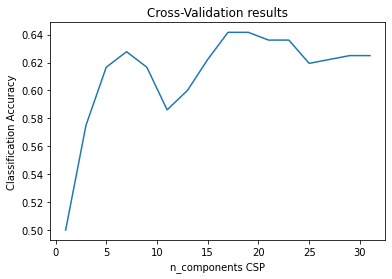

In [88]:
def train_model(csp_components, X, y):
    csp = mne.decoding.CSP(n_components=csp_components, norm_trace=True)
    log_regressor = LogisticRegression(max_iter=10000)
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    scores = []

    for train_idx, test_idx in cv.split(y):
        y_train, y_test = y[train_idx], y[test_idx]

        X_train = csp.fit_transform(X[train_idx], y_train)
        X_test = csp.transform(X[test_idx])

        # fit classifier
        log_regressor.fit(X_train, y_train)

        scores.append(log_regressor.score(X_test, y_test))
        
    return np.mean(scores) #Returns mean accuracy for this hyperparameter value

n_components = np.arange(1,33,2)
print(n_components)
accuracy = []

for number in n_components:
    accuracy.append( train_model(int(number), X, y) )

plt.plot(n_components, accuracy)
plt.xlabel("n_components CSP")
plt.ylabel("Classification Accuracy")
plt.title("Cross-Validation results")



## Results

We can derive from above experiments the following: 

1. Using Logistic Regression with CSP values gives better classification accuracy than using raw signal values.
2. As we increase the number of subjects for our experiment the classification accuracy goes down. At the four subject mark, the classification accuracy goes down below 70%.
3. As we increase the number of subjects, the hyperparameter for CSP, the number of components for spatial filtering, increases. For more subjects, the model gives us greater accuracy for more components of the CSP filter.
4. Even without Artifact Handling or Channel Selection, we are able to achieve a good accuracy for classification of task across a couple of subjects.

### Further Tasks

Given X and y, perform Binary Classification to correctly identify an event as T1 or T2. 

<p>T1 = Clenching Fists  (Real or imagining)</p>
T2 = Moving Feet      (Real or imagining)

**Possible methods which may be used:**
1. <s>Logistic Regression (Linearly separable data only)</s>
2. State Vector Machines (RBF kernel ?)
3. Linear Discriminant Analysis
4. CNNs (High chance)
5. RNNs (Try)

**We may also try Feature Engineering and Selection to improve accuracy of our model.**
1. Artifact Handling using ICA (may be better to let the deep learning model handle it)
2. <s>Common Spatial Patterns Algorithm to extract features</s>
3. Using a subset of functionally-relevant Electrodes (channels)
4. Applying Baseline to the training data to get less noisy signal
5. Short-time Fast Fourier Transform
6. Wavelet Transform